In [1]:
import numpy as np
import os
import math
from PIL import Image

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn import metrics
from skimage.external import tifffile
from skimage.measure import compare_mse

from sklearn.decomposition import PCA, KernelPCA               # 2) PCA
from sklearn.manifold import TSNE

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model

import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
def ClusterAndPlot(n_clusters, D):
    Labels = []
    
    print(D.shape)
    HC = AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='complete').fit(D)
    print('HC Silhouette Score  {} '.format(metrics.silhouette_score(D, HC.labels_)))

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(D)
    print('kmeans Silhouette Score  {} '.format(metrics.silhouette_score(D, kmeans.labels_)))

    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(D)
    gmmlabels_ = gmm.predict(D)
    print('gmm Silhouette Score  {} '.format(metrics.silhouette_score(D, gmmlabels_)))
    
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))
    axs[0, 0].scatter(D[:, 0], D[:, 1], cmap='viridis')
    axs[0, 0].set_title('Normal')

    axs[0, 1].scatter(D[:, 0], D[:, 1], c=gmmlabels_, cmap='viridis')
    axs[0, 1].set_title('GMM')

    axs[1, 0].scatter(D[:, 0], D[:, 1], c=kmeans.labels_, cmap='viridis')
    axs[1, 0].set_title('K-Means')

    axs[1, 1].scatter(D[:, 0], D[:, 1], c=HC.labels_, cmap='viridis')
    axs[1, 1].set_title('HC')
    plt.show()
    
    Labels.append(HC.labels_)
    Labels.append(kmeans.labels_)
    Labels.append(gmmlabels_)
    return Labels


def pltPathologyClusters(labels):
    clusterimgDir = "../../Data/clusters_journal.PNG"
    image = Image.open(clusterimgDir) 
    plt.figure(figsize = (85,12))
    plt.imshow(image)
    plt.axis('off')
    
    sub_directories = [str(cluster) for cluster in set(labels)]
    displayImages = []
    mseList = []
    valMse = []
    
    for cluster in sub_directories:
        direct = trainData + '/{}'.format(cluster)
        if len(os.listdir(direct))-9 > 9:
            index = np.random.randint(9,len(os.listdir(direct))-9)
        else:
            index = 0
        clusterList = []
        for file in os.listdir(direct)[index:index+9]: # random sample of 9 images
            if file.endswith('.tif'):
                #image = Image.open(os.path.join(trainData, file)) 
                image = tifffile.imread(os.path.join(trainData, file))
                clusterList.append(image)
                displayImages.append(image)
        mseList.append(clusterList)
        
#         print(mseList)
#         print("Size of cluster {} is {}".format(str(cluster),len(os.listdir(direct))))
#         print("Taking images with the indices {} to {}\n".format(index, index+9))
    for clusterRow in mseList:
        Sum = 0
        for i in range(0,7,2):
            val = compare_mse(clusterRow[i], clusterRow[i+1])
            Sum += val
        valMse.append(math.ceil(Sum / 4))
            
    
    fig = plt.figure(figsize=(14, 14))
    
    columns = 9
    rows = len(sub_directories)
    print(len(displayImages))
    print(columns*rows+1)
    for i in range(1, columns*rows+1):
        img = displayImages[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
#     plt.show()
    
    return valMse

def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)

def clusterintoDirectories(labels):
    directory = trainData
    sub_directories = [str(cluster) for cluster in set(labels)]
    
    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            for cluster in sub_directories: # count of distinct elements = no. of clusters
                os.makedirs(directory + '/{}'.format(cluster) , exist_ok=True)

    for i in range(len(image_names)):
        # if there isnt already a symlink of this image in the coressponding subdirectory
        if image_names[i] not in os.listdir(directory + '/' + sub_directories[labels[i]]): 
            symlink_rel(directory + '/{}'.format(image_names[i]) , 
                       directory + '/{}'.format(labels[i]) + '/' + image_names[i])



In [3]:
## Data loading, and standardizing
trainData = "../../Data/train"

new_train = []
image_names = []

# Test on 1000 images
for filename in os.listdir(trainData):
    if filename.endswith('.tif'):
        image = Image.open(os.path.join(trainData, filename)) 
        new_train.append(np.asarray( image, dtype="uint8" ))
        image_names.append(filename)

meanMatrix = np.asarray(new_train)
X = meanMatrix.reshape((len(new_train),-1))
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [4]:
autoencoder = load_model('../Autoencoders/SavedModels/fulldata_checkpoint_epochs10000_batch32_adam.h5') # 6 x 6 x 16
autoencoder.summary()

W0116 08:34:22.655803 4321239936 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0116 08:34:26.676891 4321239936 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        1849

In [5]:
layer_name = 'conv2d_7' # 6 x 6 x 16

intermediate_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

X = intermediate_layer_model.predict(meanMatrix)
print(X.shape)



(9999, 6, 6, 16)


(9999, 576)
(9999, 576)
HC Silhouette Score  0.2280019223690033 
kmeans Silhouette Score  0.20161373913288116 
gmm Silhouette Score  0.20122011005878448 


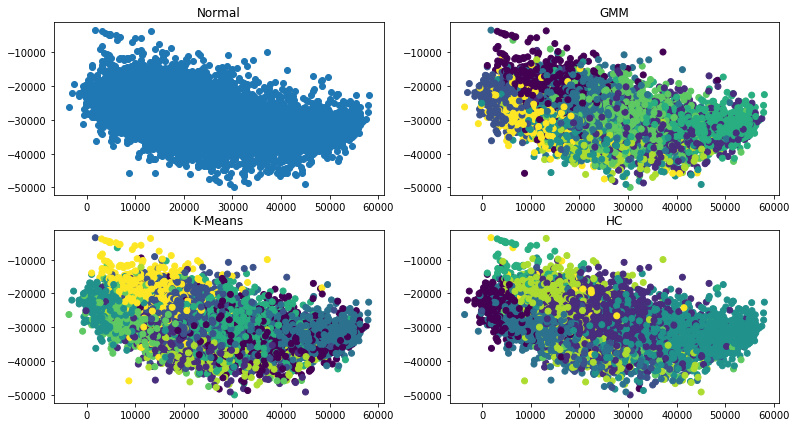

81
82


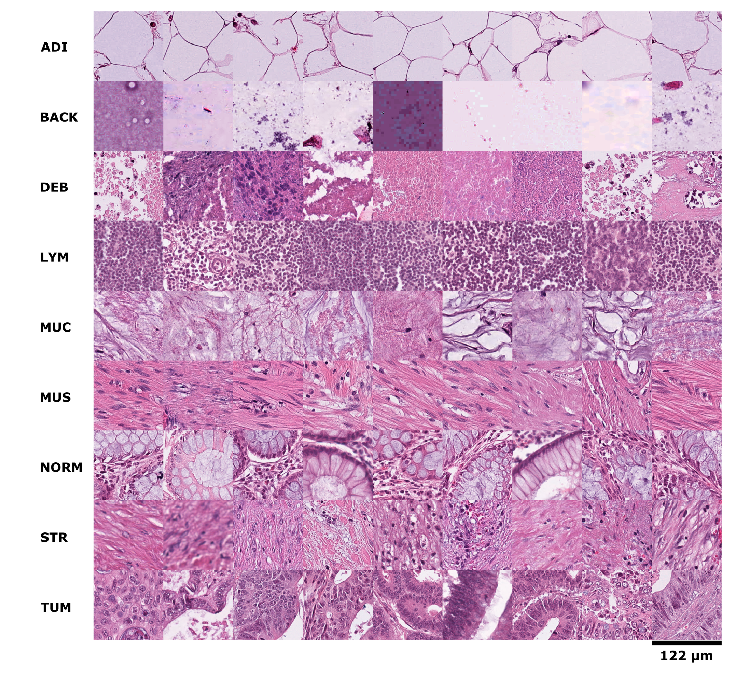

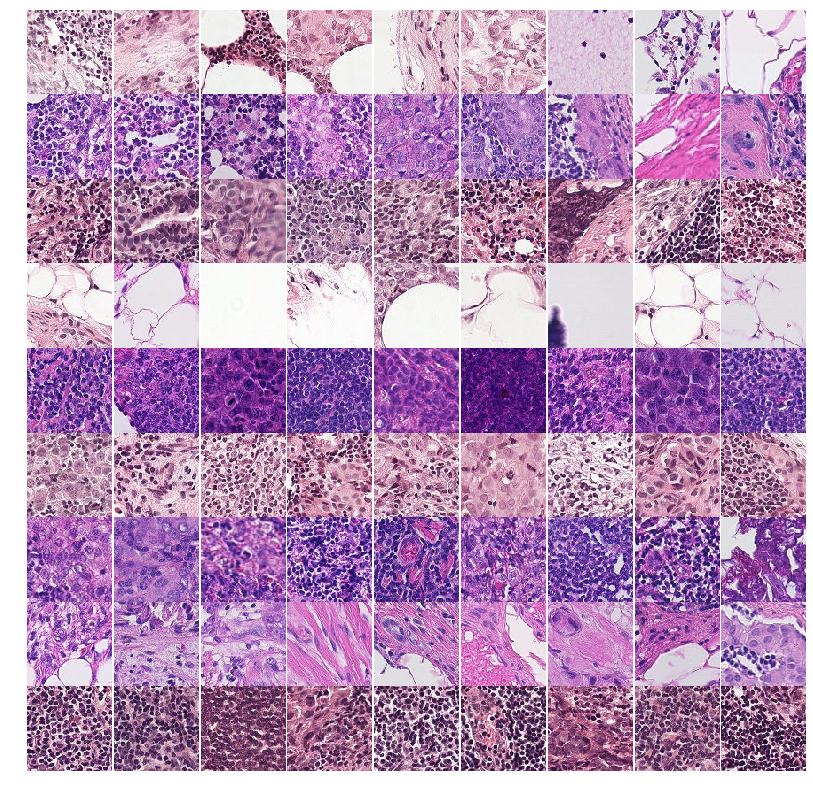

In [6]:
n_images = X.shape[0]
X = X.reshape((n_images, -1))
print(X.shape)

Labels = ClusterAndPlot(9, X)
clusterintoDirectories(Labels[1])
valMse = pltPathologyClusters(Labels[1])

In [7]:
# PCA 
pca = PCA(n_components=0.95)
transformedData = pca.fit_transform(X)
pca.n_components_

19

(9999, 19)
HC Silhouette Score  0.2516952455043793 
kmeans Silhouette Score  0.2686462104320526 
gmm Silhouette Score  0.12934966385364532 


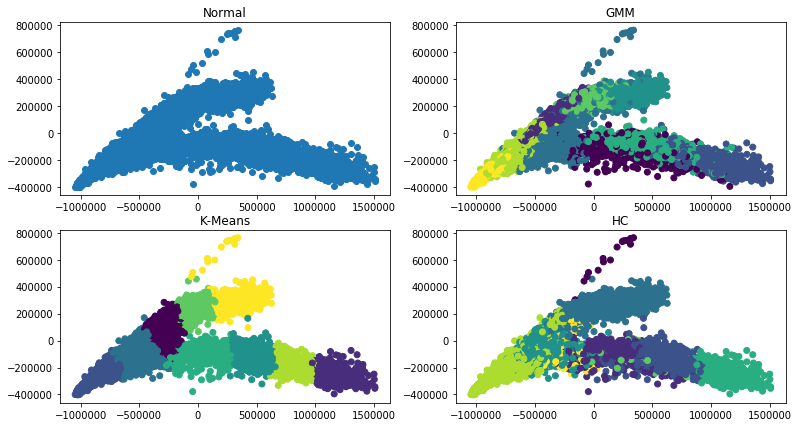

81
82


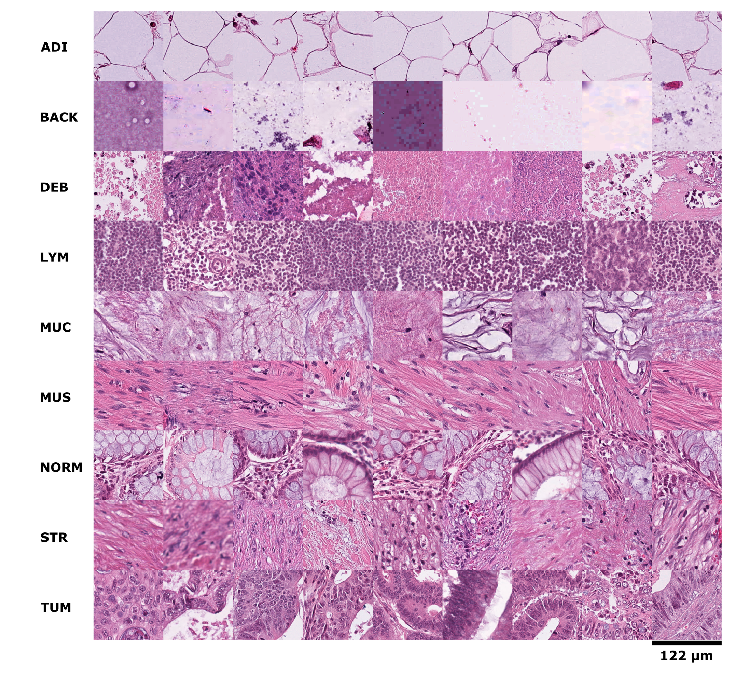

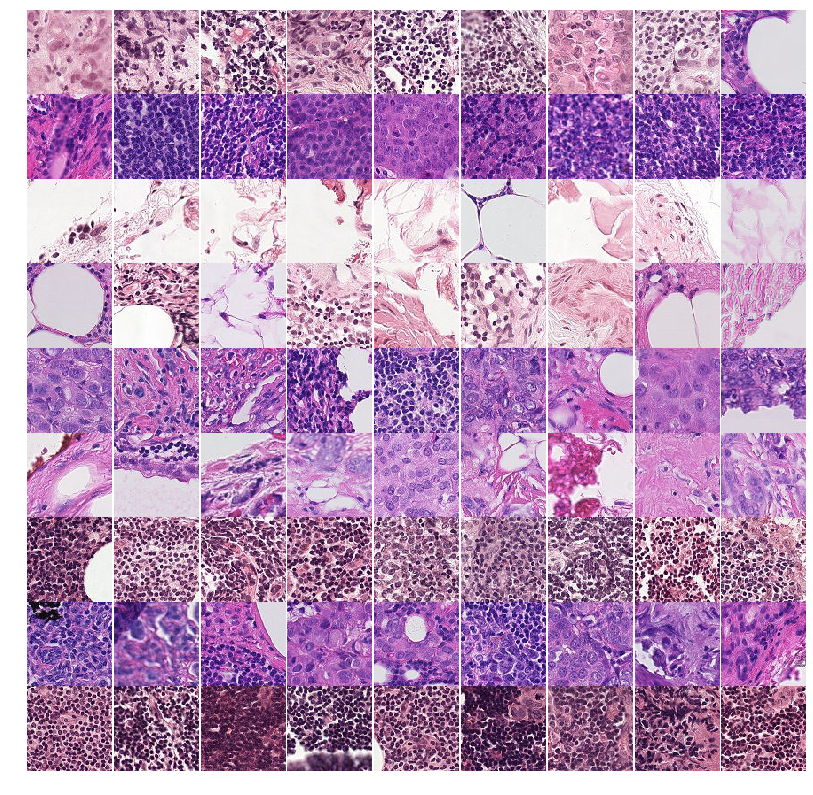

In [13]:
Labels = ClusterAndPlot(9, transformedData)
clusterintoDirectories(Labels[1])
valMse = pltPathologyClusters(Labels[1])

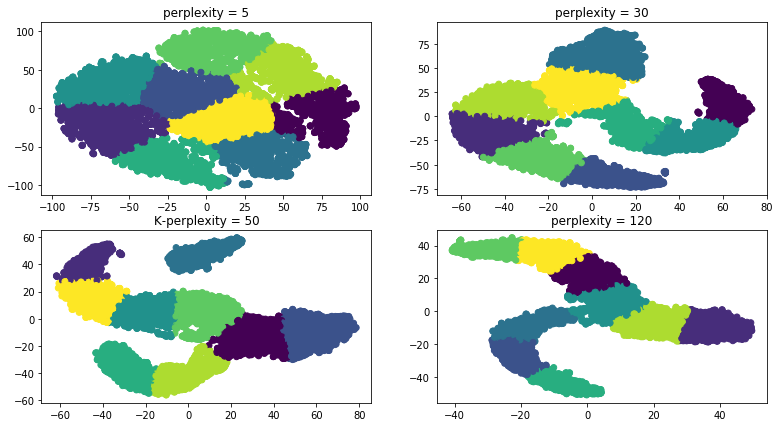

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(13, 7))

tsne1 = TSNE(n_components=2, perplexity = 5).fit_transform(transformedData)
kmeans1 = KMeans(n_clusters=9).fit(tsne1)

axs[0, 0].scatter(tsne1[:, 0], tsne1[:, 1], c=kmeans1.labels_, cmap='viridis')
axs[0, 0].set_title('perplexity = 5')

tsne2 = TSNE(n_components=2, perplexity = 30).fit_transform(transformedData)
kmeans2 = KMeans(n_clusters=9).fit(tsne2)

axs[0, 1].scatter(tsne2[:, 0], tsne2[:, 1], c=kmeans2.labels_, cmap='viridis')
axs[0, 1].set_title('perplexity = 30')

tsne3 = TSNE(n_components=2, perplexity = 50).fit_transform(transformedData)
kmeans3 = KMeans(n_clusters=9).fit(tsne3)
axs[1, 0].scatter(tsne3[:, 0], tsne3[:, 1], c=kmeans3.labels_, cmap='viridis')
axs[1, 0].set_title('perplexity = 50')

tsne4 = TSNE(n_components=2, perplexity = 120).fit_transform(transformedData)
kmeans4 = KMeans(n_clusters=9).fit(tsne4)

axs[1, 1].scatter(tsne4[:, 0], tsne4[:, 1], c=kmeans4.labels_, cmap='viridis')
axs[1, 1].set_title('perplexity = 120')
plt.show()